In [1]:
## check if notebook is running on Colab--if so, run appropriate installs and mount Google Drive
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

if 'google.colab' in str(get_ipython()):
  # install RDKit and DeepChem
  !pip install rdkit-pypi --pre deepchem git+https://github.com/PatWalters/clusterama.git
  # mount Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import time
import os
import math

from tqdm.auto import tqdm

from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools, Descriptors, Draw, rdmolops, rdMolDescriptors, Lipinski, rdFMCS, DataStructs
from rdkit.Chem.Draw import IPythonConsole

from IPython.core.display import HTML

import deepchem as dc

import mols2grid

# from clusterama import ButinaCluster, display_cluster_members


## FUNCTIONS

In [3]:
# sns.set(rc={'figure.figsize': (10, 10)})
# sns.set(font_scale=1.5)
sns.set_style('darkgrid')
sns.set_context('talk')
# plt.style.use('seaborn-dark')

In [4]:
tqdm.pandas()

In [5]:
# function for plotting distibutions as a histogram

def distribution(column, zoom_in='no'):
    plt.figure(figsize=(8, 6))
    sns.histplot(herg_df, x=column, hue='herg_inhibitor', kde=True)
    if zoom_in == 'zoom':
        plt.xlim(herg_df.logP.quantile(0.001), herg_df.logP.quantile(0.999));

In [6]:
# function for plotting boxplots grouped by herg_inhibitor

def outliers(df, column):
    plt.figure(figsize=(6,8))
    sns.boxplot(data=df, x='herg_inhibitor', y=column, hue='herg_inhibitor', )
    plt.xlabel('hERG Inhibitor');

In [7]:
# workaround for bug where molecular structure does not print with dataframe
# https://github.com/rdkit/rdkit/issues/2673
def show(df):
    return HTML(df.to_html(notebook=True))


In [8]:
# check if notebook is running on Colab and set path for data file 

def get_home_path():
  if 'google.colab' in str(get_ipython()):
    path = '/content/drive/MyDrive/GA/Capstone/ka_capstone'
  else:
    path = '..'
  
  return path


In [9]:
# view all columns in dataframe
pd.set_option('display.max.columns', None)

## Read data

In [10]:
    
# read hERG data into dataframe 
herg_df = pd.read_csv(f'{get_home_path()}/data/interim/herg_data.csv')


In [11]:
herg_df.sample(5)

Pubchem_SID                                             SMILES  \
30752      49816489  O=C(/C=C/c1ccc(F)cc1)Nc1ccc(S(=O)(=O)N2CCOCC2)cc1   
240781     24818092     COc1ccc(CNC(=O)CCCNC(=O)c2cn(C)nc2C(F)(F)F)cc1   
21283      24823096         O=C(/C=C/c1ccco1)NCC(=O)N/N=C/c1ccc(Cl)cc1   
221222     49672683            Cc1ccc(NC(=O)C(c2ccccc2)c2ccccc2)c(O)c1   
198156     57261677            COC(=O)c1ccc(NC(=O)COC(=O)CCC2CCCC2)cc1   

        hERG_at_1uM  hERG_at_10uM  herg_inhibitor       mw     logP    PSA  \
30752       13.4899       9.00468               0  390.436  2.49850  75.71   
240781       9.2789      -2.18152               0  398.385  2.27390  85.25   
21283      -18.5185     -13.07322               0  331.759  2.21270  83.70   
221222       8.6085      -8.04322               0  317.388  4.47122  49.33   
198156       0.9997       4.15668               0  333.384  2.92530  81.70   

        H_bond_donors  H_bond_acceptors  num_heteroatoms  total_num_rings  \
30752               1                 4                8                3   
240781              2                 5               10                2   
21283               2                 4                7                2   
221222              2                 2                3                3   
198156              1                 5                6                2   

        aromatic_rings  num_rotatable_bonds  num_stereocenters  formal_charge  \
30752                2                    5                  0              0   
240781               2                    8                  0              0   
21283                2                    6                  0              0   
221222               3                    4                  0              0   
198156               1                    7                  0              0   

        SMILES_length  ro5_violations  \
30752              49               0   
240781             46               0   
21283              42               0   
221222             39               0   
198156             39               0   

                                         adjacency_matrix     label  
30752   [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  inactive  
240781  [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  inactive  
21283   [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  inactive  
221222  [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  inactive  
198156  [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  inactive

In [ ]:
# add image of molecule to dataframe
herg_df['mol'] = herg_df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/306865 [00:00<?, ?it/s]

In [ ]:
pattern = Chem.MolFromSmiles('CN(C)C')

In [ ]:
pattern2 = Chem.MolFromSmarts('[N;D3]')

In [ ]:
show(herg_df.loc[:,['mol']].sample(5))

In [ ]:
PandasTools.FrameToGridImage(herg_df.loc[[mol.HasSubstructMatch(pattern) for mol in herg_df.mol]].sample(8), column='mol', legendsCol='Pubchem_SID', molsPerRow=4, subImgSize=(400,400))


In [ ]:
PandasTools.FrameToGridImage(herg_df.loc[[mol.HasSubstructMatch(pattern2) for mol in herg_df.mol]].sample(8), column='mol', legendsCol='Pubchem_SID', molsPerRow=4, subImgSize=(400,400))
print(len(herg_df.loc[[mol.HasSubstructMatch(pattern) for mol in herg_df.mol]]))
print(len(herg_df.loc[[mol.HasSubstructMatch(pattern2) for mol in herg_df.mol]]))

In [39]:
herg_df.loc[[mol.HasSubstructMatch(pattern) for mol in herg_df.mol]].groupby('herg_inhibitor')['Pubchem_SID'].count()

herg_inhibitor
0    109092
1      9641
Name: Pubchem_SID, dtype: int64

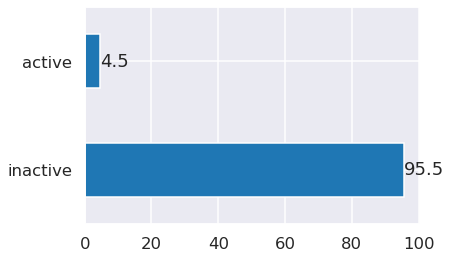

In [32]:
# get distribution of active and inactive compounds
fig, ax = plt.subplots()
# bars = ax.barh(indexes, values)
bars = (herg_df['label'].value_counts(normalize=True).round(3)*100).plot(kind='barh');
# ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)
    


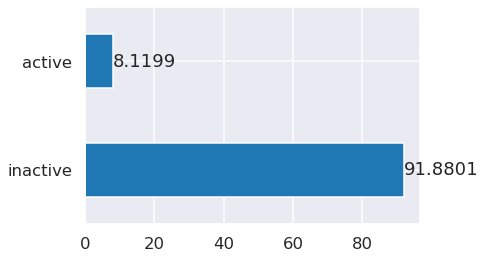

In [35]:
fig, ax = plt.subplots()
bars = (herg_df.loc[[mol.HasSubstructMatch(pattern) for mol in herg_df.mol]]['label'].value_counts(normalize=True)*100).plot(kind='barh')
for bars in ax.containers:
    ax.bar_label(bars)

In [47]:
herg_df.loc[[not mol.HasSubstructMatch(pattern) for mol in herg_df.mol], :].groupby('herg_inhibitor')['Pubchem_SID'].count()

herg_inhibitor
0    184029
1      4103
Name: Pubchem_SID, dtype: int64

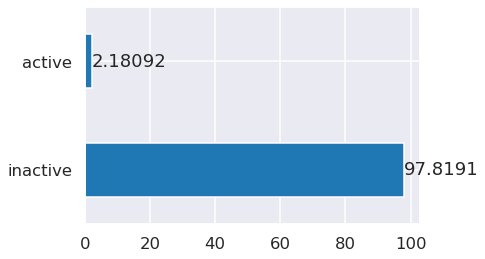

In [36]:
fig, ax = plt.subplots()
bars = (herg_df.loc[[not mol.HasSubstructMatch(pattern) for mol in herg_df.mol]]['label'].value_counts(normalize=True)*100).plot(kind='barh')
for bars in ax.containers:
    ax.bar_label(bars)

In [ ]:
Dra

In [27]:
show(herg_df.loc[[mol.HasSubstructMatch(pattern2) for mol in herg_df.mol] ,['mol']]).head()

KeyboardInterrupt: 

In [ ]:
for mol in herg_df.mol:
    print(mol.HasSubstructMatch(pattern2))

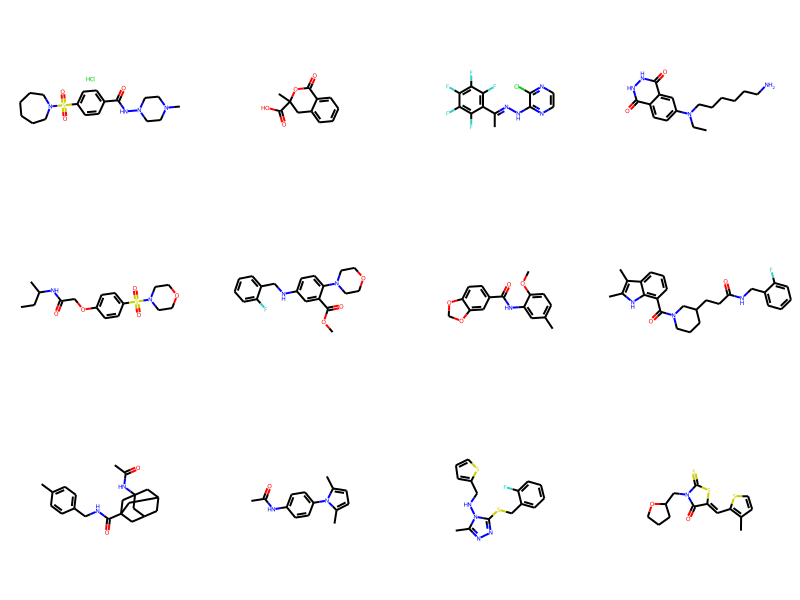

In [28]:
Draw.MolsToGridImage(herg_df.mol.sample(12), molsPerRow=4)

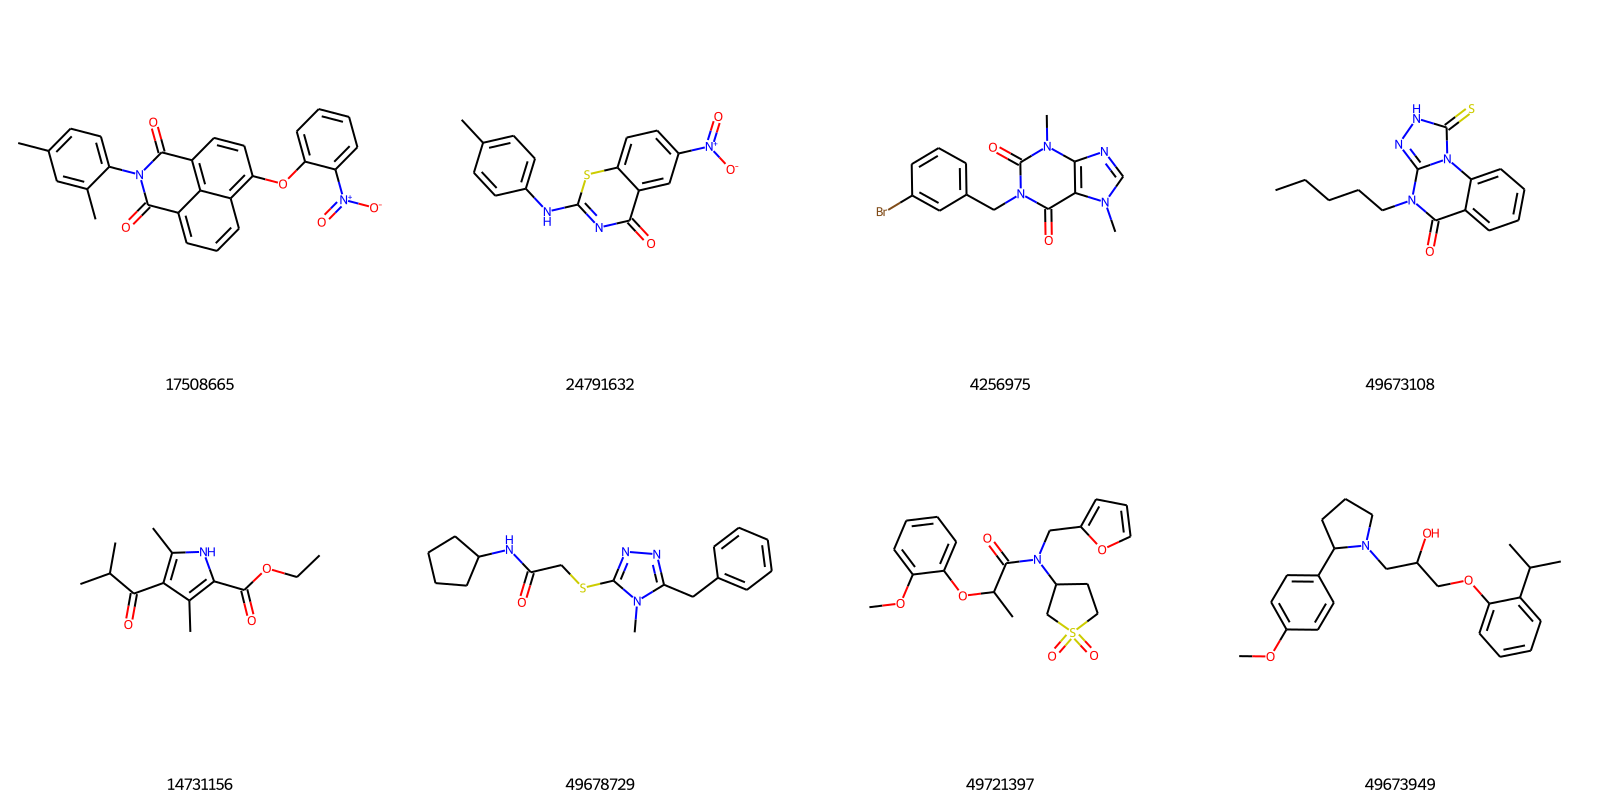

In [31]:
PandasTools.FrameToGridImage(herg_df.sample(8), column='mol', legendsCol='Pubchem_SID', molsPerRow=4, subImgSize=(400,400))


## EDA

In [15]:
# are all of the PubChem IDs unique?
herg_df.Pubchem_SID.nunique() == herg_df.shape[0]

True

In [16]:
# are all of the SMILES values unique?
herg_df.SMILES.nunique() == herg_df.shape[0]

True

In [15]:
herg_df.SMILES.duplicated().any()

False

In [16]:
herg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306865 entries, 0 to 306864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Pubchem_SID          306865 non-null  int64  
 1   SMILES               306865 non-null  object 
 2   hERG_at_1uM          306865 non-null  float64
 3   hERG_at_10uM         306865 non-null  float64
 4   herg_inhibitor       306865 non-null  int64  
 5   mw                   306865 non-null  float64
 6   logP                 306865 non-null  float64
 7   num_stereocenters    306865 non-null  int64  
 8   num_heteroatoms      306865 non-null  int64  
 9   total_num_rings      306865 non-null  int64  
 10  aromatic_rings       306865 non-null  int64  
 11  num_rotatable_bonds  306865 non-null  int64  
 12  PSA                  306865 non-null  float64
 13  formal_charge        306865 non-null  int64  
 14  H_bond_donors        306865 non-null  int64  
 15  H_bond_acceptors 

In [17]:
# get distribution of active and inactive compounds
herg_df['herg_inhibitor'].value_counts(normalize=True).round(3)*100


0    95.5
1     4.5
Name: herg_inhibitor, dtype: float64

In [39]:
herg_df.describe()

Pubchem_SID    hERG_at_1uM   hERG_at_10uM  herg_inhibitor  \
count  3.068650e+05  306865.000000  306865.000000   306865.000000   
mean   2.810340e+07       6.246021      -2.777348        0.044788   
std    1.809249e+07      11.196587      20.572885        0.206839   
min    8.421210e+05    -299.017000    -284.172920        0.000000   
25%    1.474224e+07       2.781400     -10.247820        0.000000   
50%    2.480566e+07       8.253800       1.635380        0.000000   
75%    4.966690e+07      12.443000      10.515580        0.000000   
max    8.514922e+07     126.489200     213.104180        1.000000   

                  mw           logP            PSA  H_bond_donors  \
count  306865.000000  306865.000000  306865.000000  306865.000000   
mean      360.740823       2.938132      74.905614       1.171463   
std        78.630572       1.248801      28.200163       0.891638   
min        60.056000     -13.054800       0.000000       0.000000   
25%       306.409000       2.178220      55.400000       1.000000   
50%       358.419000       2.982200      72.950000       1.000000   
75%       412.352000       3.749100      91.980000       2.000000   
max      1701.206000      12.605800     777.980000      25.000000   

       H_bond_acceptors  num_heteroatoms  total_num_rings  aromatic_rings  \
count     306865.000000     306865.00000    306865.000000   306865.000000   
mean           4.889479          6.94962         3.004445        2.264918   
std            1.835904          2.22014         0.984356        0.914907   
min            0.000000          0.00000         0.000000        0.000000   
25%            4.000000          5.00000         2.000000        2.000000   
50%            5.000000          7.00000         3.000000        2.000000   
75%            6.000000          8.00000         4.000000        3.000000   
max           46.000000         46.00000        22.000000       10.000000   

       num_rotatable_bonds  num_stereocenters  formal_charge  SMILES_length  \
count        306865.000000      306865.000000  306865.000000  306865.000000   
mean              4.975784           0.395842       0.000257      43.339016   
std               2.344302           0.874818       0.030367      11.073268   
min               0.000000           0.000000      -3.000000       6.000000   
25%               3.000000           0.000000       0.000000      36.000000   
50%               5.000000           0.000000       0.000000      43.000000   
75%               6.000000           1.000000       0.000000      50.000000   
max              55.000000          30.000000       2.000000     263.000000   

       ro5_violations  
count   306865.000000  
mean         0.078435  
std          0.304246  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          4.000000

In [40]:
# columns to exclude from EDA
no_eda_columns = ['Pubchem_SID', 'SMILES', 'label']
target_columns = ['herg_inhibitor', 'hERG_at_1uM',	'hERG_at_10uM']

In [41]:
# separate variables into continuous and discrete
eda_columns_dis = [i for i in herg_df.columns.symmetric_difference(no_eda_columns).symmetric_difference(target_columns) if herg_df[i].nunique() / herg_df.shape[0] < 0.05]
eda_columns_con = [i for i in herg_df.columns.symmetric_difference(no_eda_columns).symmetric_difference(target_columns) if herg_df[i].nunique() / herg_df.shape[0] > 0.05]

In [42]:
# group min, mean, and max by hERG inhibition - discrete variables
herg_df.groupby('herg_inhibitor')[eda_columns_dis].agg(['mean', 'min', 'max', 'median'])

H_bond_acceptors                H_bond_donors                 \
                           mean min max median          mean min max median   
herg_inhibitor                                                                
0                      4.878927   0  46    5.0      1.182307   0  25    1.0   
1                      5.114523   0  12    5.0      0.940192   0   6    1.0   

               SMILES_length                 aromatic_rings                 \
                        mean min  max median           mean min max median   
herg_inhibitor                                                               
0                  43.125774   6  263   42.0       2.252445   0  10    2.0   
1                  47.886860  17  121   47.0       2.530923   0   6    2.0   

               formal_charge                num_heteroatoms                 \
                        mean min max median            mean min max median   
herg_inhibitor                                                               
0                   0.000290  -3   2    0.0        6.943030   0  46    7.0   
1                  -0.000437  -2   1    0.0        7.090148   1  17    7.0   

               num_rotatable_bonds                num_stereocenters          \
                              mean min max median              mean min max   
herg_inhibitor                                                                
0                         4.927006   0  55    5.0          0.396021   0  30   
1                         6.016080   0  22    6.0          0.392026   0  10   

                      ro5_violations                total_num_rings          \
               median           mean min max median            mean min max   
herg_inhibitor                                                                
0                 0.0       0.077050   0   4    0.0        2.980871   0  22   
1                 0.0       0.107974   0   2    0.0        3.507203   0   9   

                       
               median  
herg_inhibitor         
0                 3.0  
1                 3.0

In [43]:
# group min, mean, and max by hERG inhibition - discrete variables
herg_df.groupby('label')[eda_columns_con].agg(['mean', 'min', 'max', 'median'])

/tmp/ipykernel_24600/3067394519.py:2: FutureWarning: ['adjacency_matrix', 'mol'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  herg_df.groupby('label')[eda_columns_con].agg(['mean', 'min', 'max', 'median'])


PSA                          logP                              \
               mean  min     max median      mean       min      max   median   
label                                                                           
active    69.704918  0.0  221.12  67.87  3.440596  -2.25856   8.0488  3.47733   
inactive  75.149466  0.0  777.98  73.20  2.914572 -13.05480  12.6058  2.95550   

                  mw                               
                mean      min       max    median  
label                                              
active    404.698920  149.581   766.962  404.3775  
inactive  358.679694   60.056  1701.206  355.5070

In [25]:
# group min, mean, and max by hERG inhibition - discrete variables
herg_df.groupby('label')[eda_columns_dis].mean().T

label                   active   inactive
H_bond_acceptors      5.114523   4.878927
H_bond_donors         0.940192   1.182307
SMILES_length        47.886860  43.125774
aromatic_rings        2.530923   2.252445
formal_charge        -0.000437   0.000290
num_heteroatoms       7.090148   6.943030
num_rotatable_bonds   6.016080   4.927006
num_stereocenters     0.392026   0.396021
ro5_violations        0.107974   0.077050
total_num_rings       3.507203   2.980871

In [52]:
# group min, mean, and max by hERG inhibition - discrete variables
print(herg_df.groupby('herg_inhibitor')[eda_columns_dis].mean().T.to_markdown())

|                     |            0 |            1 |
|:--------------------|-------------:|-------------:|
| H_bond_acceptors    |  4.87893     |  5.11452     |
| H_bond_donors       |  1.18231     |  0.940192    |
| SMILES_length       | 43.1258      | 47.8869      |
| aromatic_rings      |  2.25245     |  2.53092     |
| formal_charge       |  0.000289983 | -0.000436554 |
| num_heteroatoms     |  6.94303     |  7.09015     |
| num_rotatable_bonds |  6.94303     |  7.09015     |
| num_stereocenters   |  0.396021    |  0.392026    |
| ro5_violations      |  0.0770501   |  0.107974    |
| total_num_rings     |  2.98087     |  3.5072      |


|                     |            0 |            1 |
|:--------------------|-------------:|-------------:|
| H_bond_acceptors    |  4.87893     |  5.11452     |
| H_bond_donors       |  1.18231     |  0.940192    |
| SMILES_length       | 43.1258      | 47.8869      |
| aromatic_rings      |  2.25245     |  2.53092     |
| formal_charge       |  0.000289983 | -0.000436554 |
| num_heteroatoms     |  6.94303     |  7.09015     |
| num_rotatable_bonds |  6.94303     |  7.09015     |
| num_stereocenters   |  0.396021    |  0.392026    |
| ro5_violations      |  0.0770501   |  0.107974    |
| total_num_rings     |  2.98087     |  3.5072      |

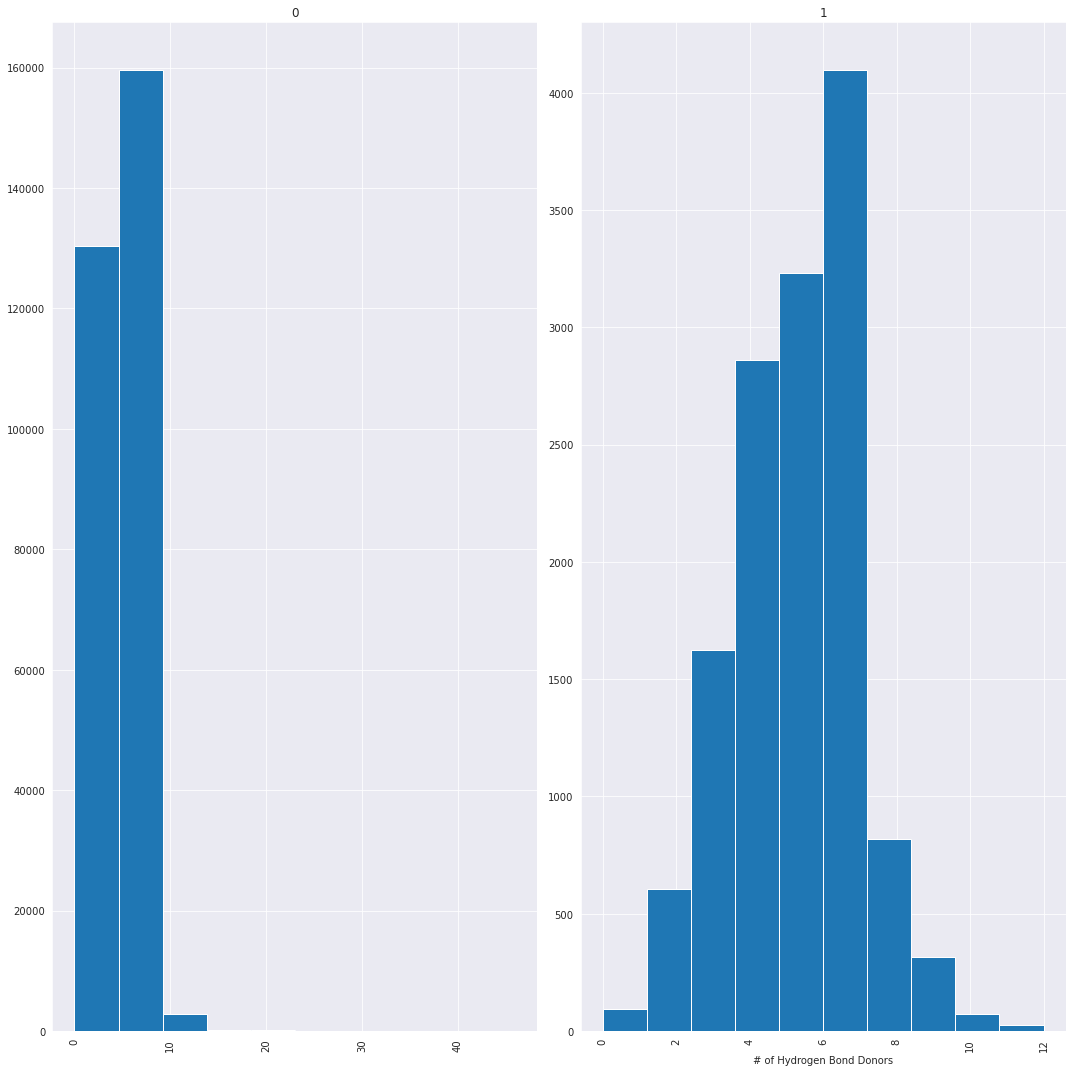

In [22]:
herg_df.hist(column='H_bond_acceptors', by='herg_inhibitor', figsize=(15, 15))
plt.xlabel('# of Hydrogen Bond Donors')
plt.tight_layout();

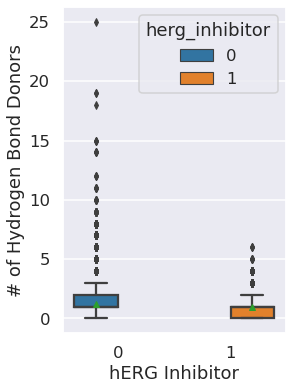

In [36]:
plt.figure(figsize=(4,6))
box_plot = sns.boxplot(data=herg_df, x='herg_inhibitor', y='H_bond_donors', hue='herg_inhibitor', showmeans=True )
# medians = herg_df.groupby(['herg_inhibitor'])['H_bond_donors'].mean()
# vertical_offset = herg_df['H_bond_donors'].mean() * 0.6 # offset from median for display

# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
#             horizontalalignment='center',size='x-small',color='black',weight='semibold')
plt.ylabel('# of Hydrogen Bond Donors')
plt.xlabel('hERG Inhibitor');

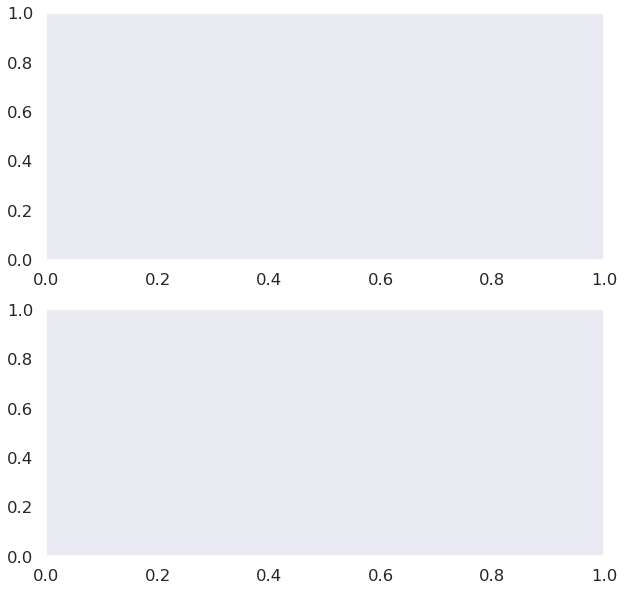

In [76]:
fig, ax = plt.subplots(,1,figsize=(10,10))
fi

sns.boxplot(data=herg_df, x='hERG_inhib', y='H_bond_donors')

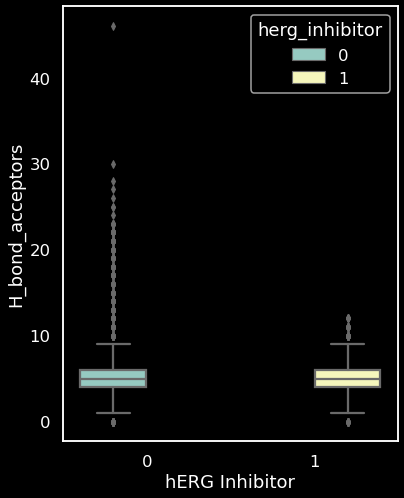

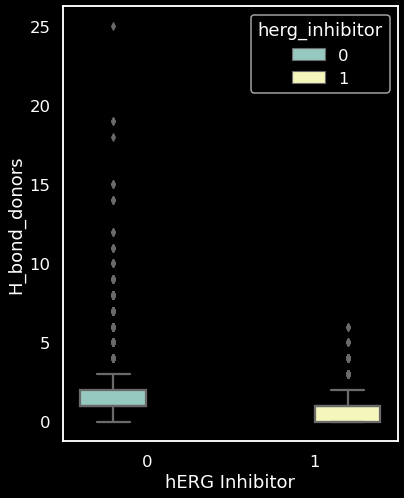

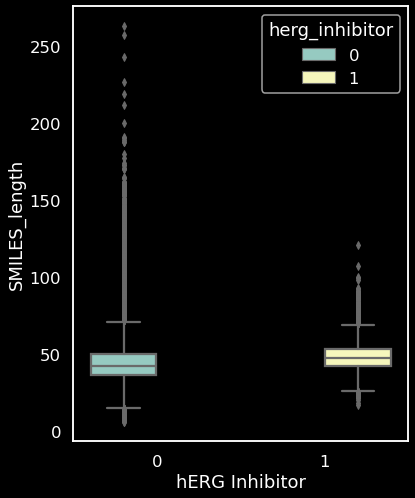

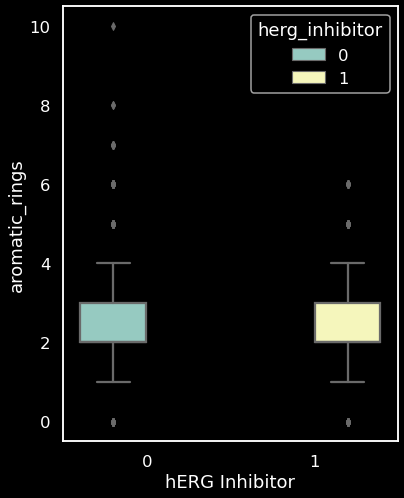

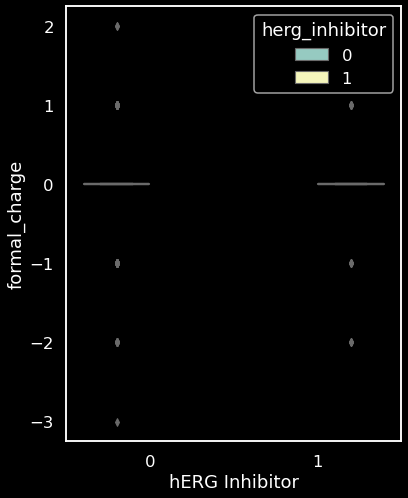

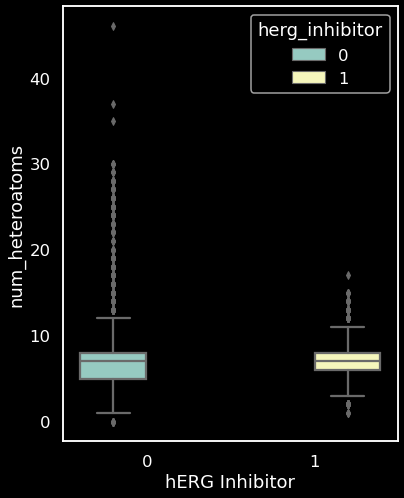

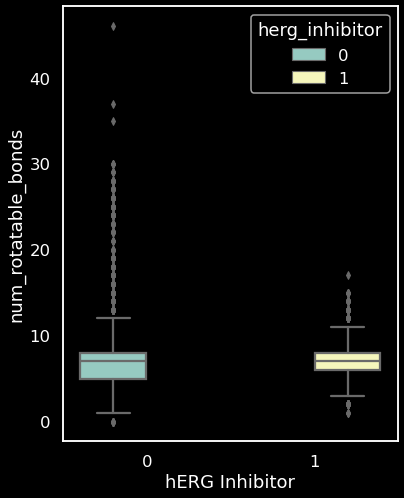

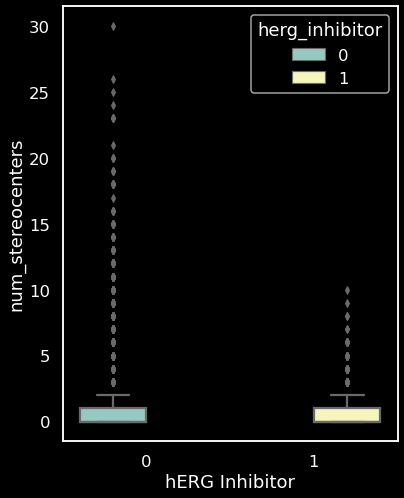

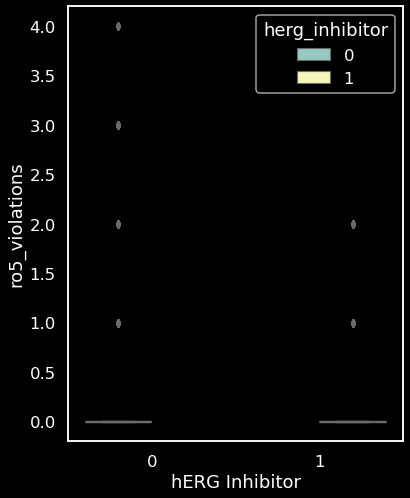

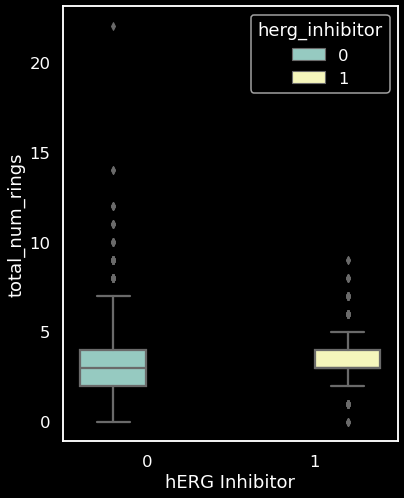

In [79]:
# plt.figure(figsize=(8, 10))
# sns.boxplot(data=herg_df, x='herg_inhibitor', y='H_bond_donors');
for col in eda_columns_dis:
    outliers(herg_df, col)

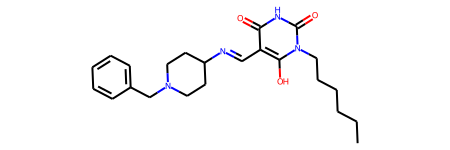

In [45]:
herg_df.mol[6]

In [ ]:

# mol_with_atom_index(herg_df.Mol[6])


In [47]:
Chem.MolToSmiles(herg_df.mol[6])


'CCCCCCn1c(O)c(C=NC2CCN(Cc3ccccc3)CC2)c(=O)[nH]c1=O'

In [ ]:
A = rdmolops.GetAdjacencyMatrix(herg_df.Mol[5])
A = np.asmatrix(A)
A

matrix([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32)

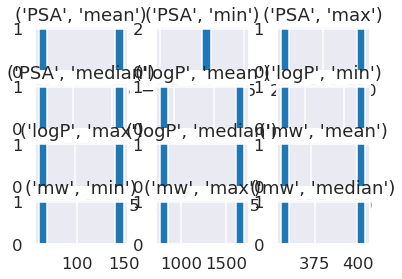

In [ ]:
# group min, mean, max, and median by hERG inhibition - continuous variables
herg_df.groupby('herg_inhibitor')[eda_columns_con].agg(['mean', 'min', 'max', 'median'])

<Figure size 864x864 with 0 Axes>

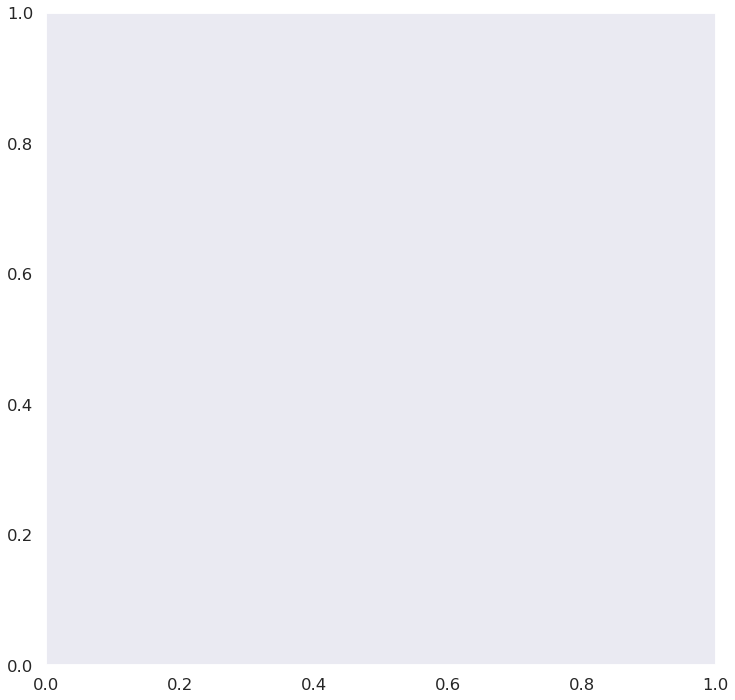

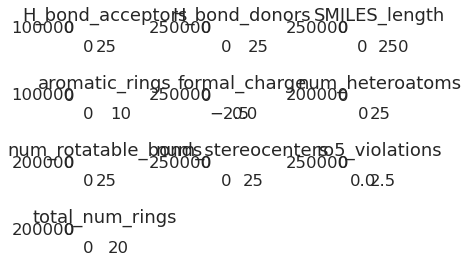

In [55]:
plt.figure(figsize=(12,12))
fig, ax = plt.subplots(figsize=(12,12))
herg_df[eda_columns_dis].hist()
plt.tight_layout();

In [46]:
# group min, mean, max, and median by hERG inhibition - continuous variables
herg_df.groupby('herg_inhibitor')[eda_columns_con].count()
# plt.tight_layout();

PSA    logP      mw
herg_inhibitor                        
0               293121  293121  293121
1                13744   13744   13744

hERG inhbition appears to be defined as producing an electrophysiology signal at or below -50 at a concentration of 10 uM

Non-hERG inhibitiors (0) have a higher polar surface area, a lower logP, and lower molecular weight on average

The distribution of molecular weights among inhibitors seems quite (oddly?) symmetrical, as the mean and median are about the same -- the same is true regarding non-inhibitors, albeit to a lesser degree

Median molecular weight of blockers (404) slightly higher than that of non-blockers (355)

USE CHEMBL DATA AS TEST DATA

In [22]:
## show unique values for each discrete variable
for i in tqdm(herg_df[eda_columns_dis].columns):
    print(f'{i}: {herg_df[i].nunique()}')
    print(herg_df[i].unique())
    print('*'*80)

  0%|          | 0/10 [00:00<?, ?it/s]

H_bond_acceptors: 31
[ 3  7  2  6  5  8  4  9 11 10  0  1 12 21 23 14 27 18 13 16 17 22 15 19
 20 28 25 26 24 30 46]
********************************************************************************
H_bond_donors: 18
[ 1  0  3  2  5  4  8  7  6 10  9 11 14 12 19 15 18 25]
********************************************************************************
SMILES_length: 175
[ 22  43  39  56  68  23  50  46  31  47  42  53  54  34  57  59  41  32
  29  55  37  44  48  45  24  49  52  30  38  78  40  27  26  33  35  36
  67  28  51  64  58  20  21  62  60  65  19  70  66  82  71 155  94  61
  13  72  75  83  63  25  91  69  84  76  97  17 142  80  81  92  73  95
  85  88 121  74  18  77 125 102  98 126  96 107  89  16 105 108   7 127
 135 113  79  10  93  86  99 153  14   8 101 122  87 115 112 104  90 103
 109 123 133 124 150   9 132 131  12 200 111  15 118 106 119 158 160 116
 137 100 156 120 117 145 139 138 149 161 144 143  11   6 130 134 148 110
 170 173 136 140 157 164 114 146 128 174 227

In [23]:
sum([herg_df[i].nunique() for i in eda_columns_dis]) 

368

In [24]:
eda_columns_dis

['H_bond_acceptors',
 'H_bond_donors',
 'SMILES_length',
 'aromatic_rings',
 'formal_charge',
 'num_heteroatoms',
 'num_rotatable_bonds',
 'num_stereocenters',
 'ro5_violations',
 'total_num_rings']

NameError: name 'ax' is not defined

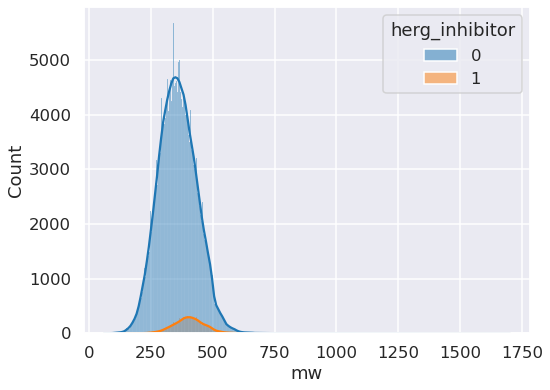

In [52]:
plt.figure(figsize=(8, 6))
sns.histplot(herg_df, x='mw', hue='herg_inhibitor', kde=True)

# axvline: axis vertical line
ax.axvline(500, color="black", ls="--", label="Median hour")
ax.legend();

In [25]:
(herg_df.groupby('herg_inhibitor').aromatic_rings.value_counts(normalize=True)*100)

herg_inhibitor  aromatic_rings
0               2                 43.286561
                3                 29.497034
                1                 17.450814
                4                  7.202486
                0                  1.789022
                5                  0.730415
                6                  0.039915
                7                  0.002729
                8                  0.000682
                10                 0.000341
1               2                 42.760477
                3                 36.757858
                4                 10.681024
                1                  8.214494
                5                  1.149593
                0                  0.334692
                6                  0.101863
Name: aromatic_rings, dtype: float64

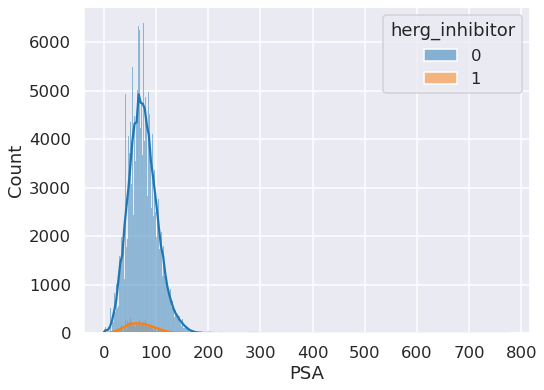

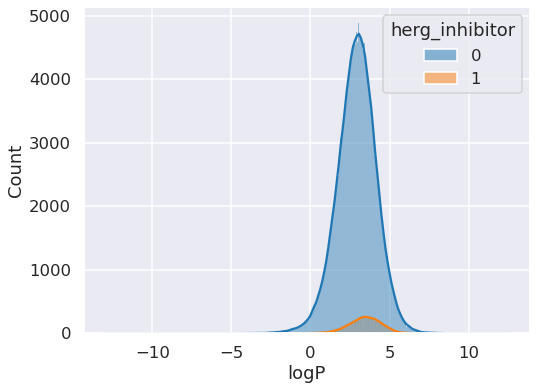

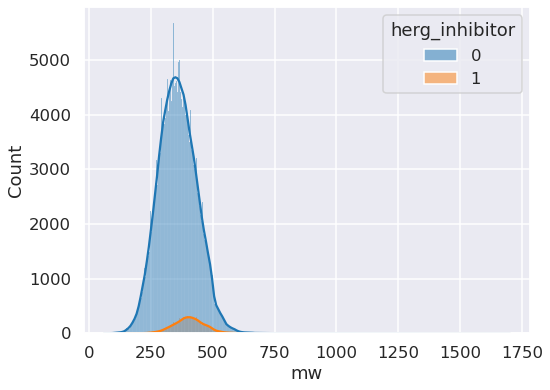

In [38]:
# distribution of continuous variables
for col in eda_columns_con:
    distribution(col)

In [ ]:
# distribution of continuous variables
fig = plt.figure(figsize=(25,18))
for i, c in enumerate(eda_columns_con):
    ax = fig.add_subplot(
       math.ceil(len(eda_columns_con) / 4), 4, i + 1)
    # plot the continent on these axes
    sns.histplot(herg_df, x=c, hue='herg_inhibitor', kde=True)
    sns.countplot(x=c, data=herg_df,  ax=ax, hue='herg_inhibitor')
    ax.set_title(c)
fig.tight_layout();
# plt.show();

Median molecular weight of blockers (404) slightly higher than that of non-blockers (355)

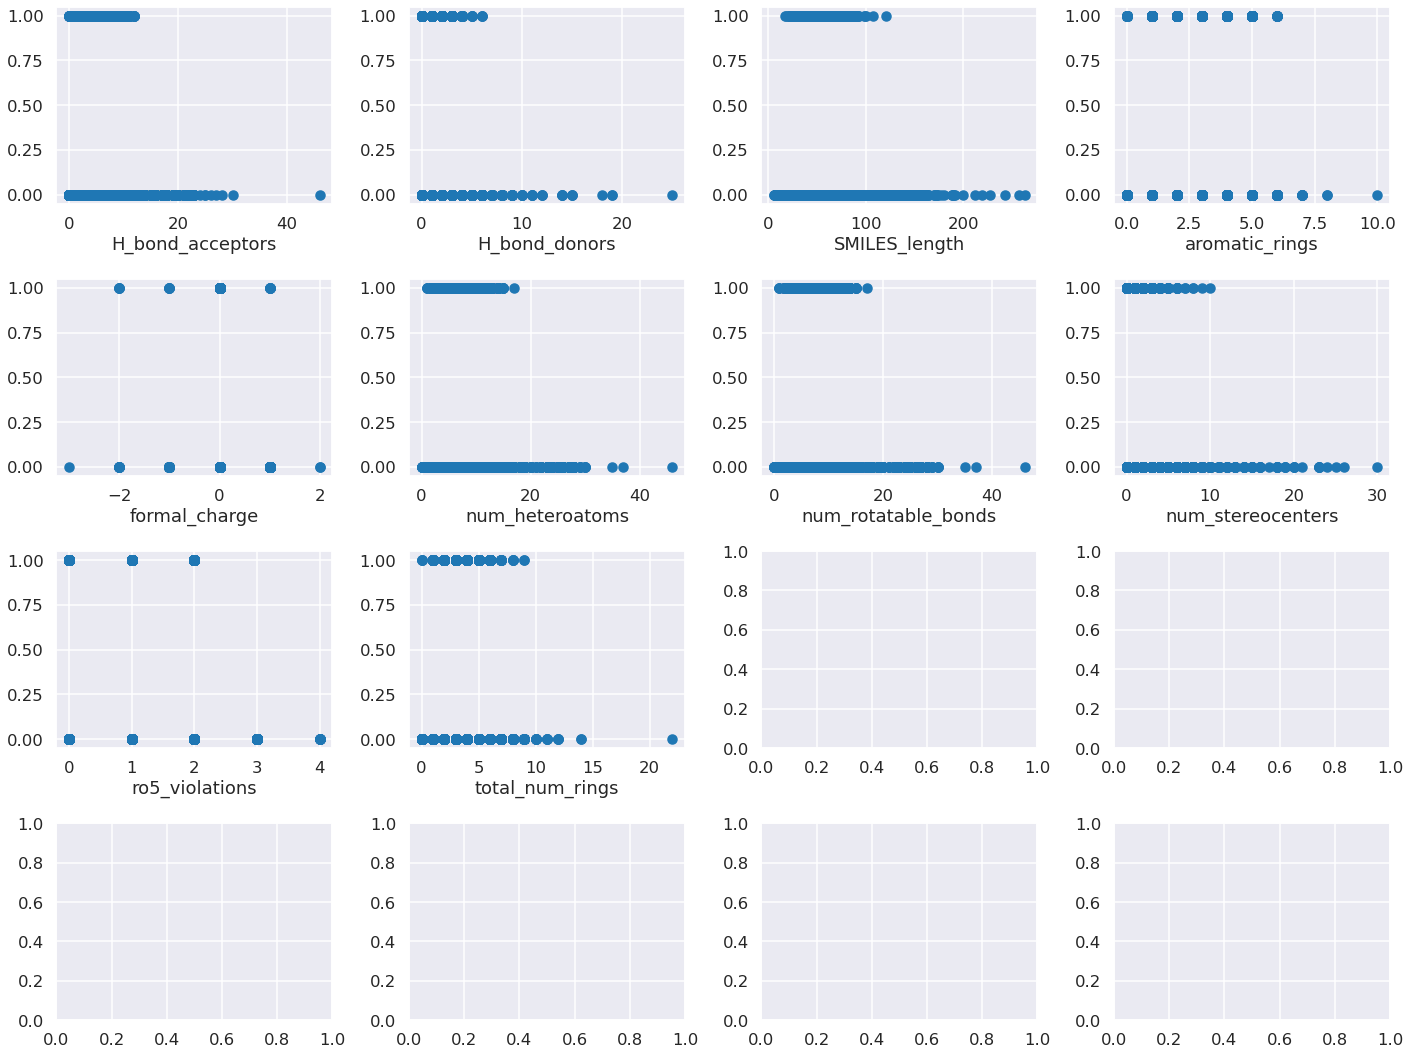

In [47]:
# Create correlation plots for discrete variables
# from Eric Bayless (except for axis labels--I figured that out)

fig,ax = plt.subplots(4,4,figsize=(20,15))

for i,j in enumerate(eda_columns_dis):
    ax[i//4][i%4].scatter(x=herg_df[j],y=herg_df['herg_inhibitor'])
    ax[i//4][i%4].set(xlabel=eda_columns_dis[i])
plt.tight_layout();
    # sns.pairplot(df_train, x_vars=cont_cols, y_vars=['SalePrice']);

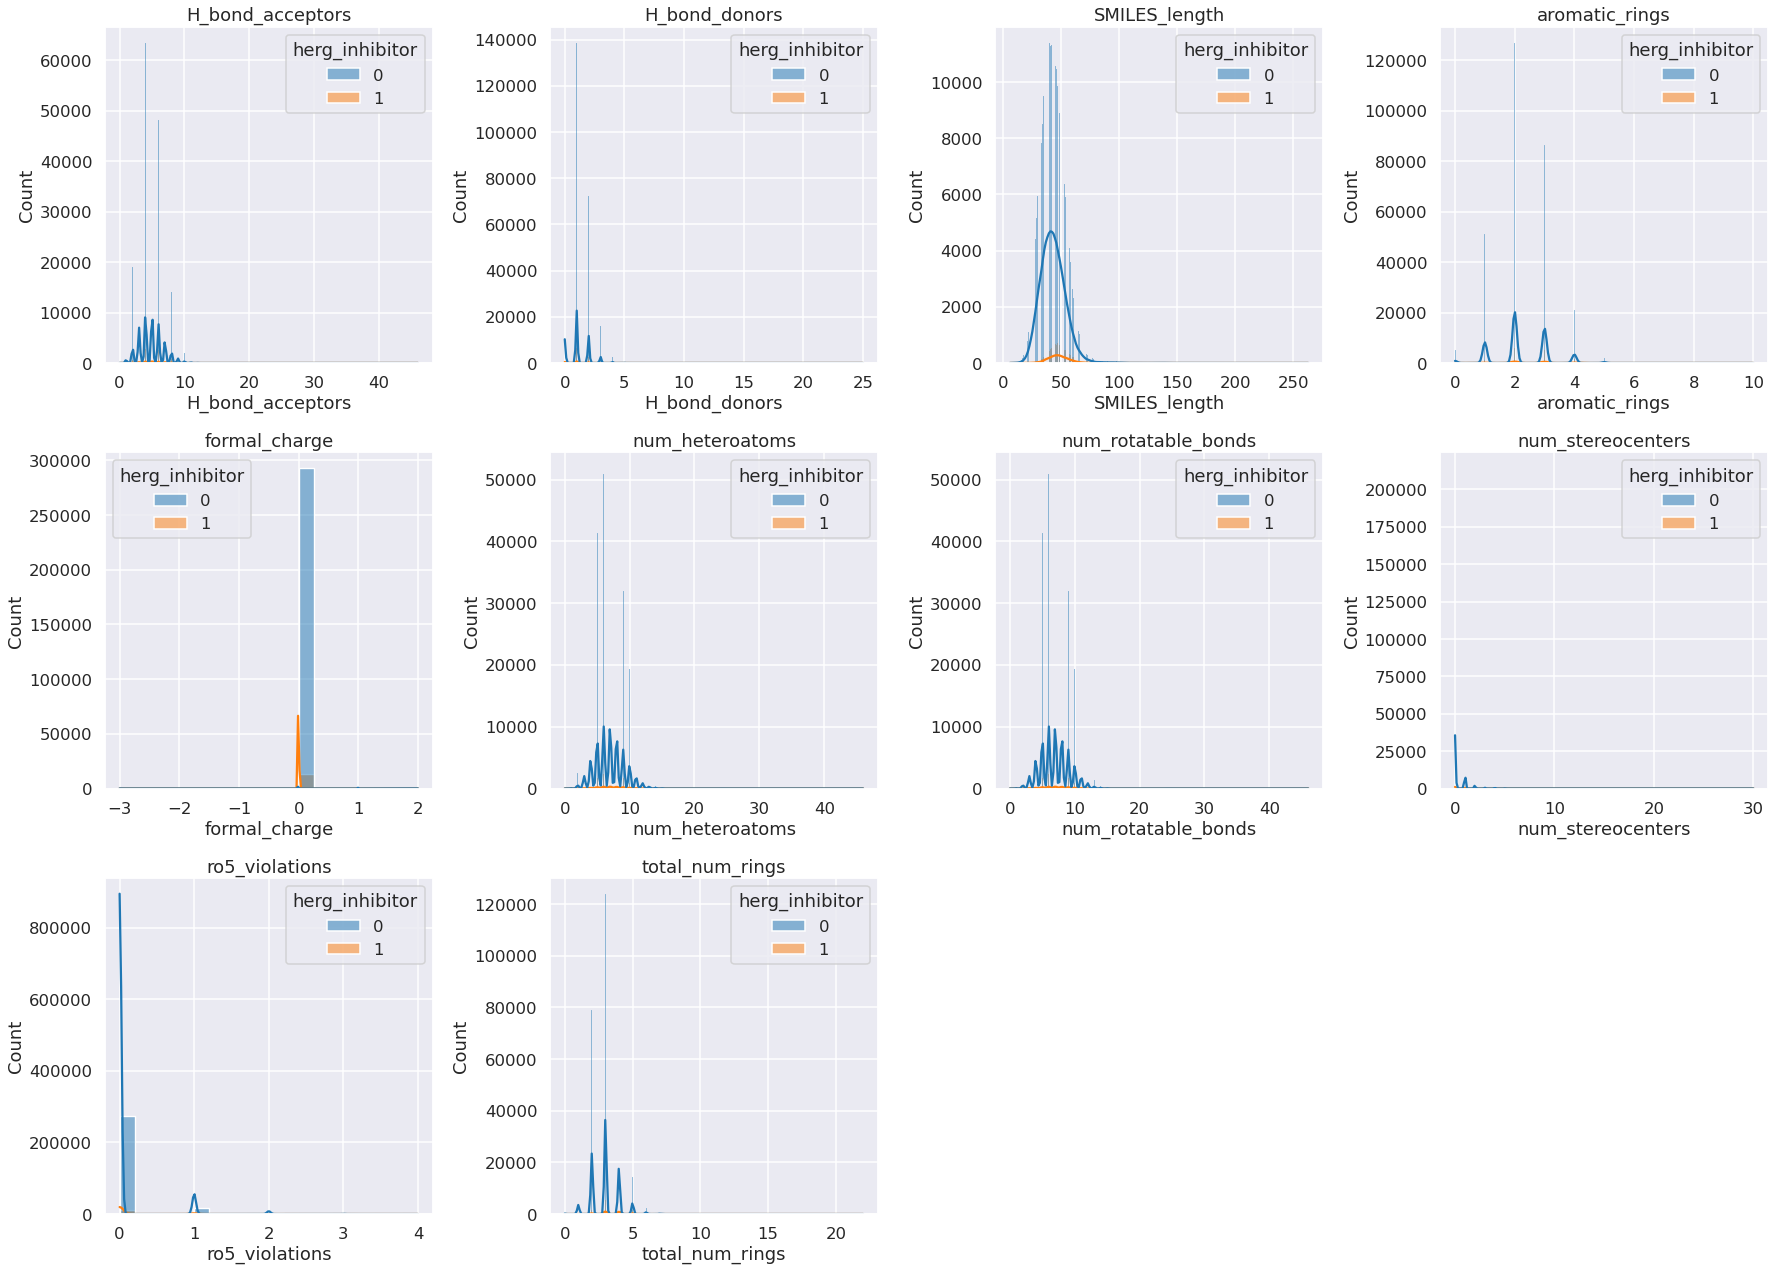

In [48]:
## https://insilico-notebook.com/en/chemdata-eda/

fig = plt.figure(figsize=(25,18))
for i, c in enumerate(eda_columns_dis):
    ax = fig.add_subplot(
       math.ceil(len(eda_columns_dis) / 4), 4, i + 1)
    # plot the continent on these axes
    sns.histplot(herg_df, x=c, hue='herg_inhibitor', kde=True)
    sns.countplot(x=c, data=herg_df,  ax=ax, hue='herg_inhibitor')
    ax.set_title(c)
fig.tight_layout();
# plt.show();

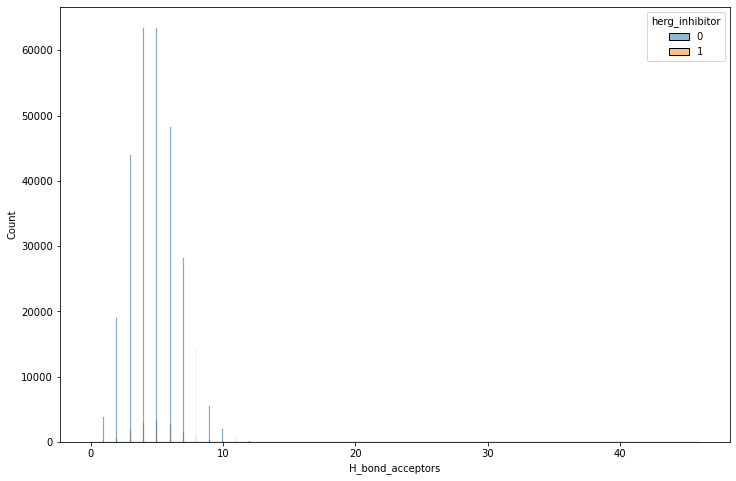

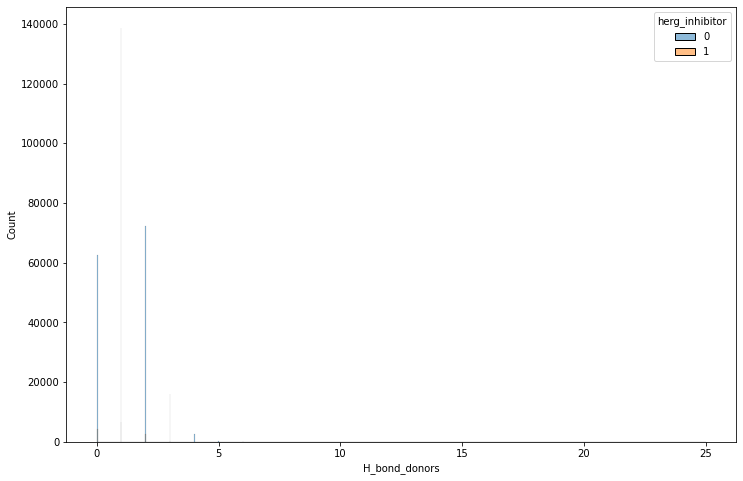

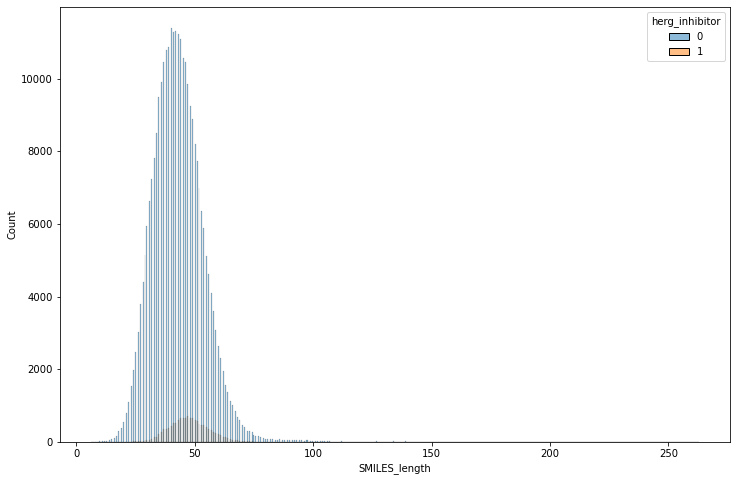

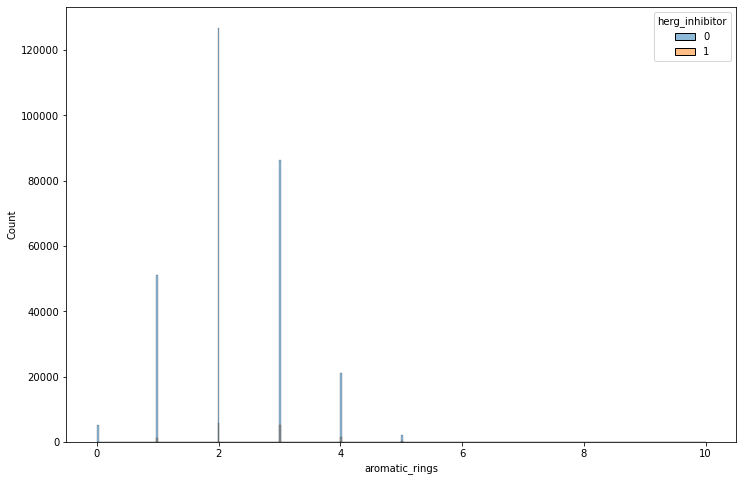

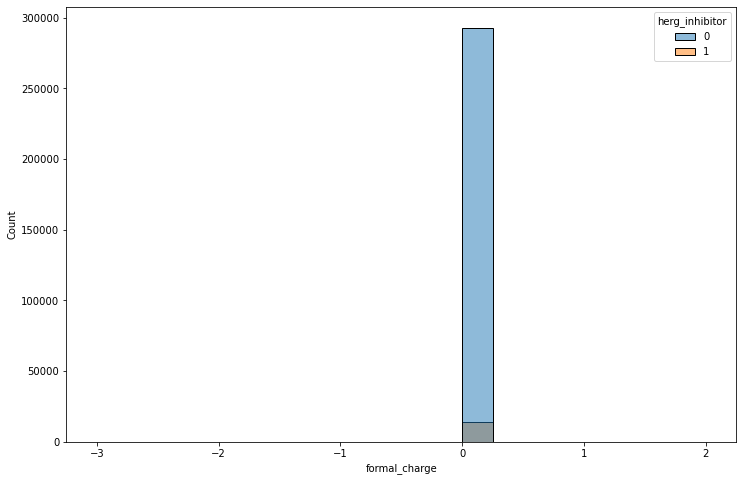

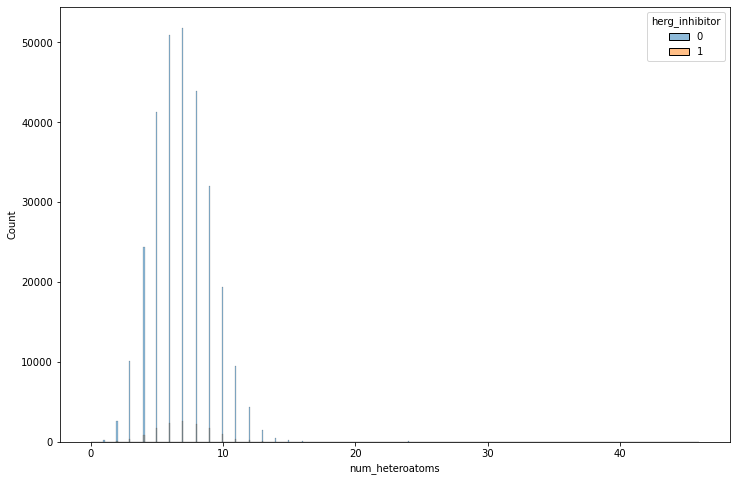

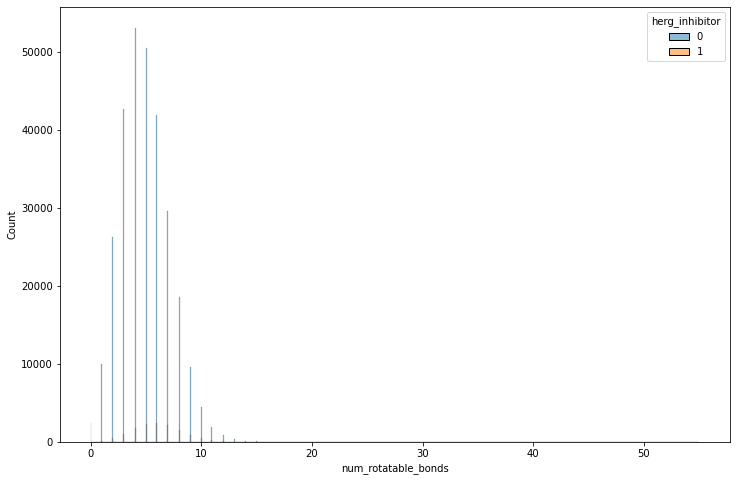

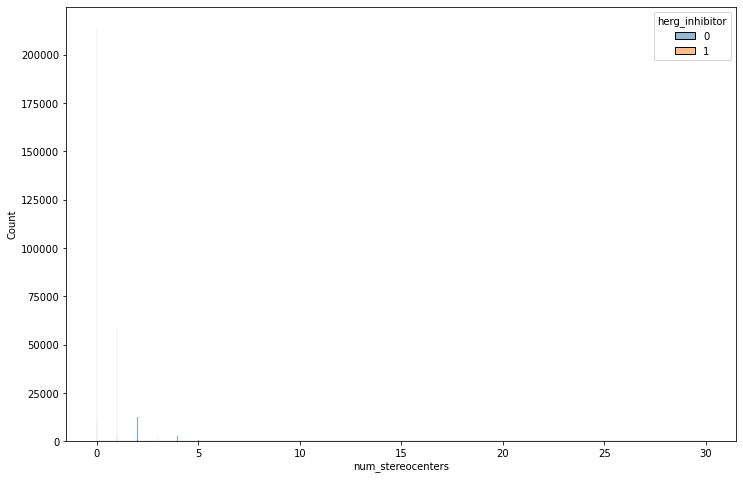

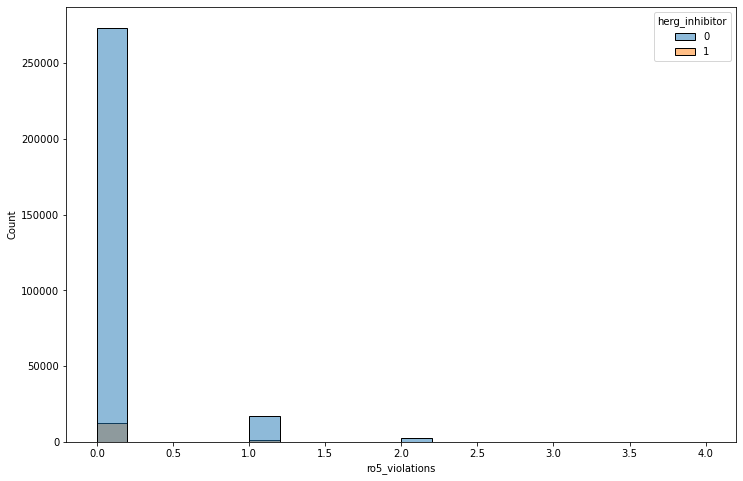

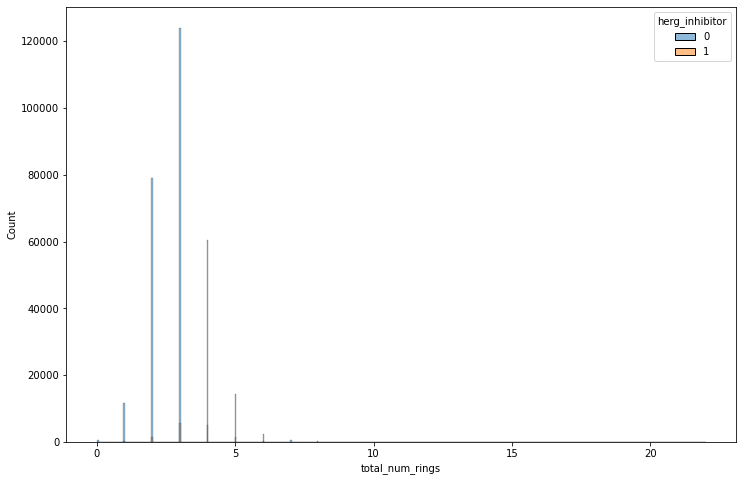

In [27]:
# distribution of discrete variables
for col in eda_columns_dis:
    distribution(col)

In [28]:
# how many compounds with molecular weight > 1000?''' '''  ''' '''
herg_df.loc[herg_df.mw >= 1000, 'Pubchem_SID'].count()

122

In [29]:
# show compounds with molecular weight > 1000
show(herg_df.loc[herg_df.mw >= 1000, :].sample(10))

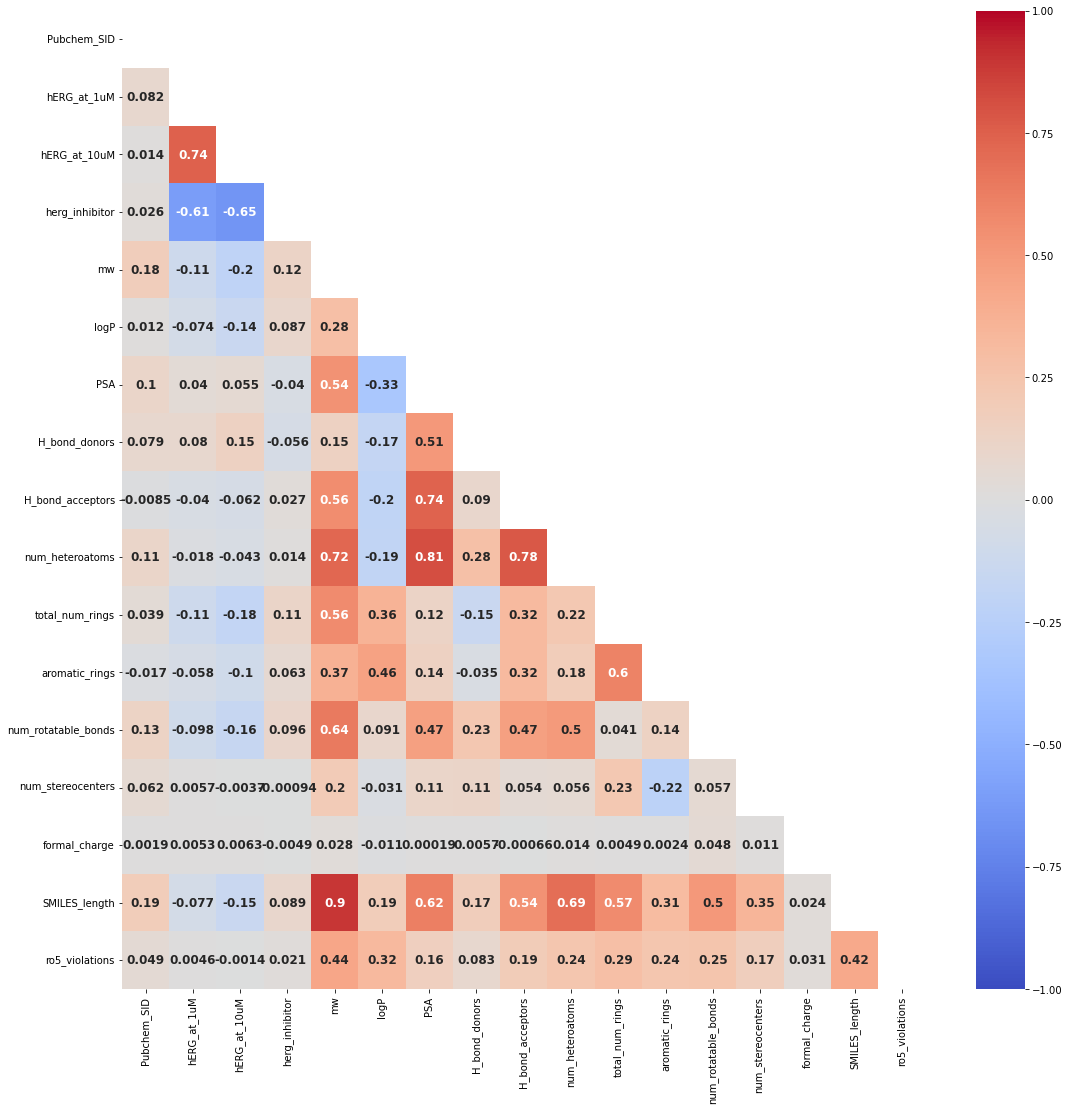

In [30]:
## Correlation heatmap

plt.figure(figsize= (18,18))

corr = herg_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=mask, cmap='coolwarm', annot_kws = {'size':12,'weight':'bold'});



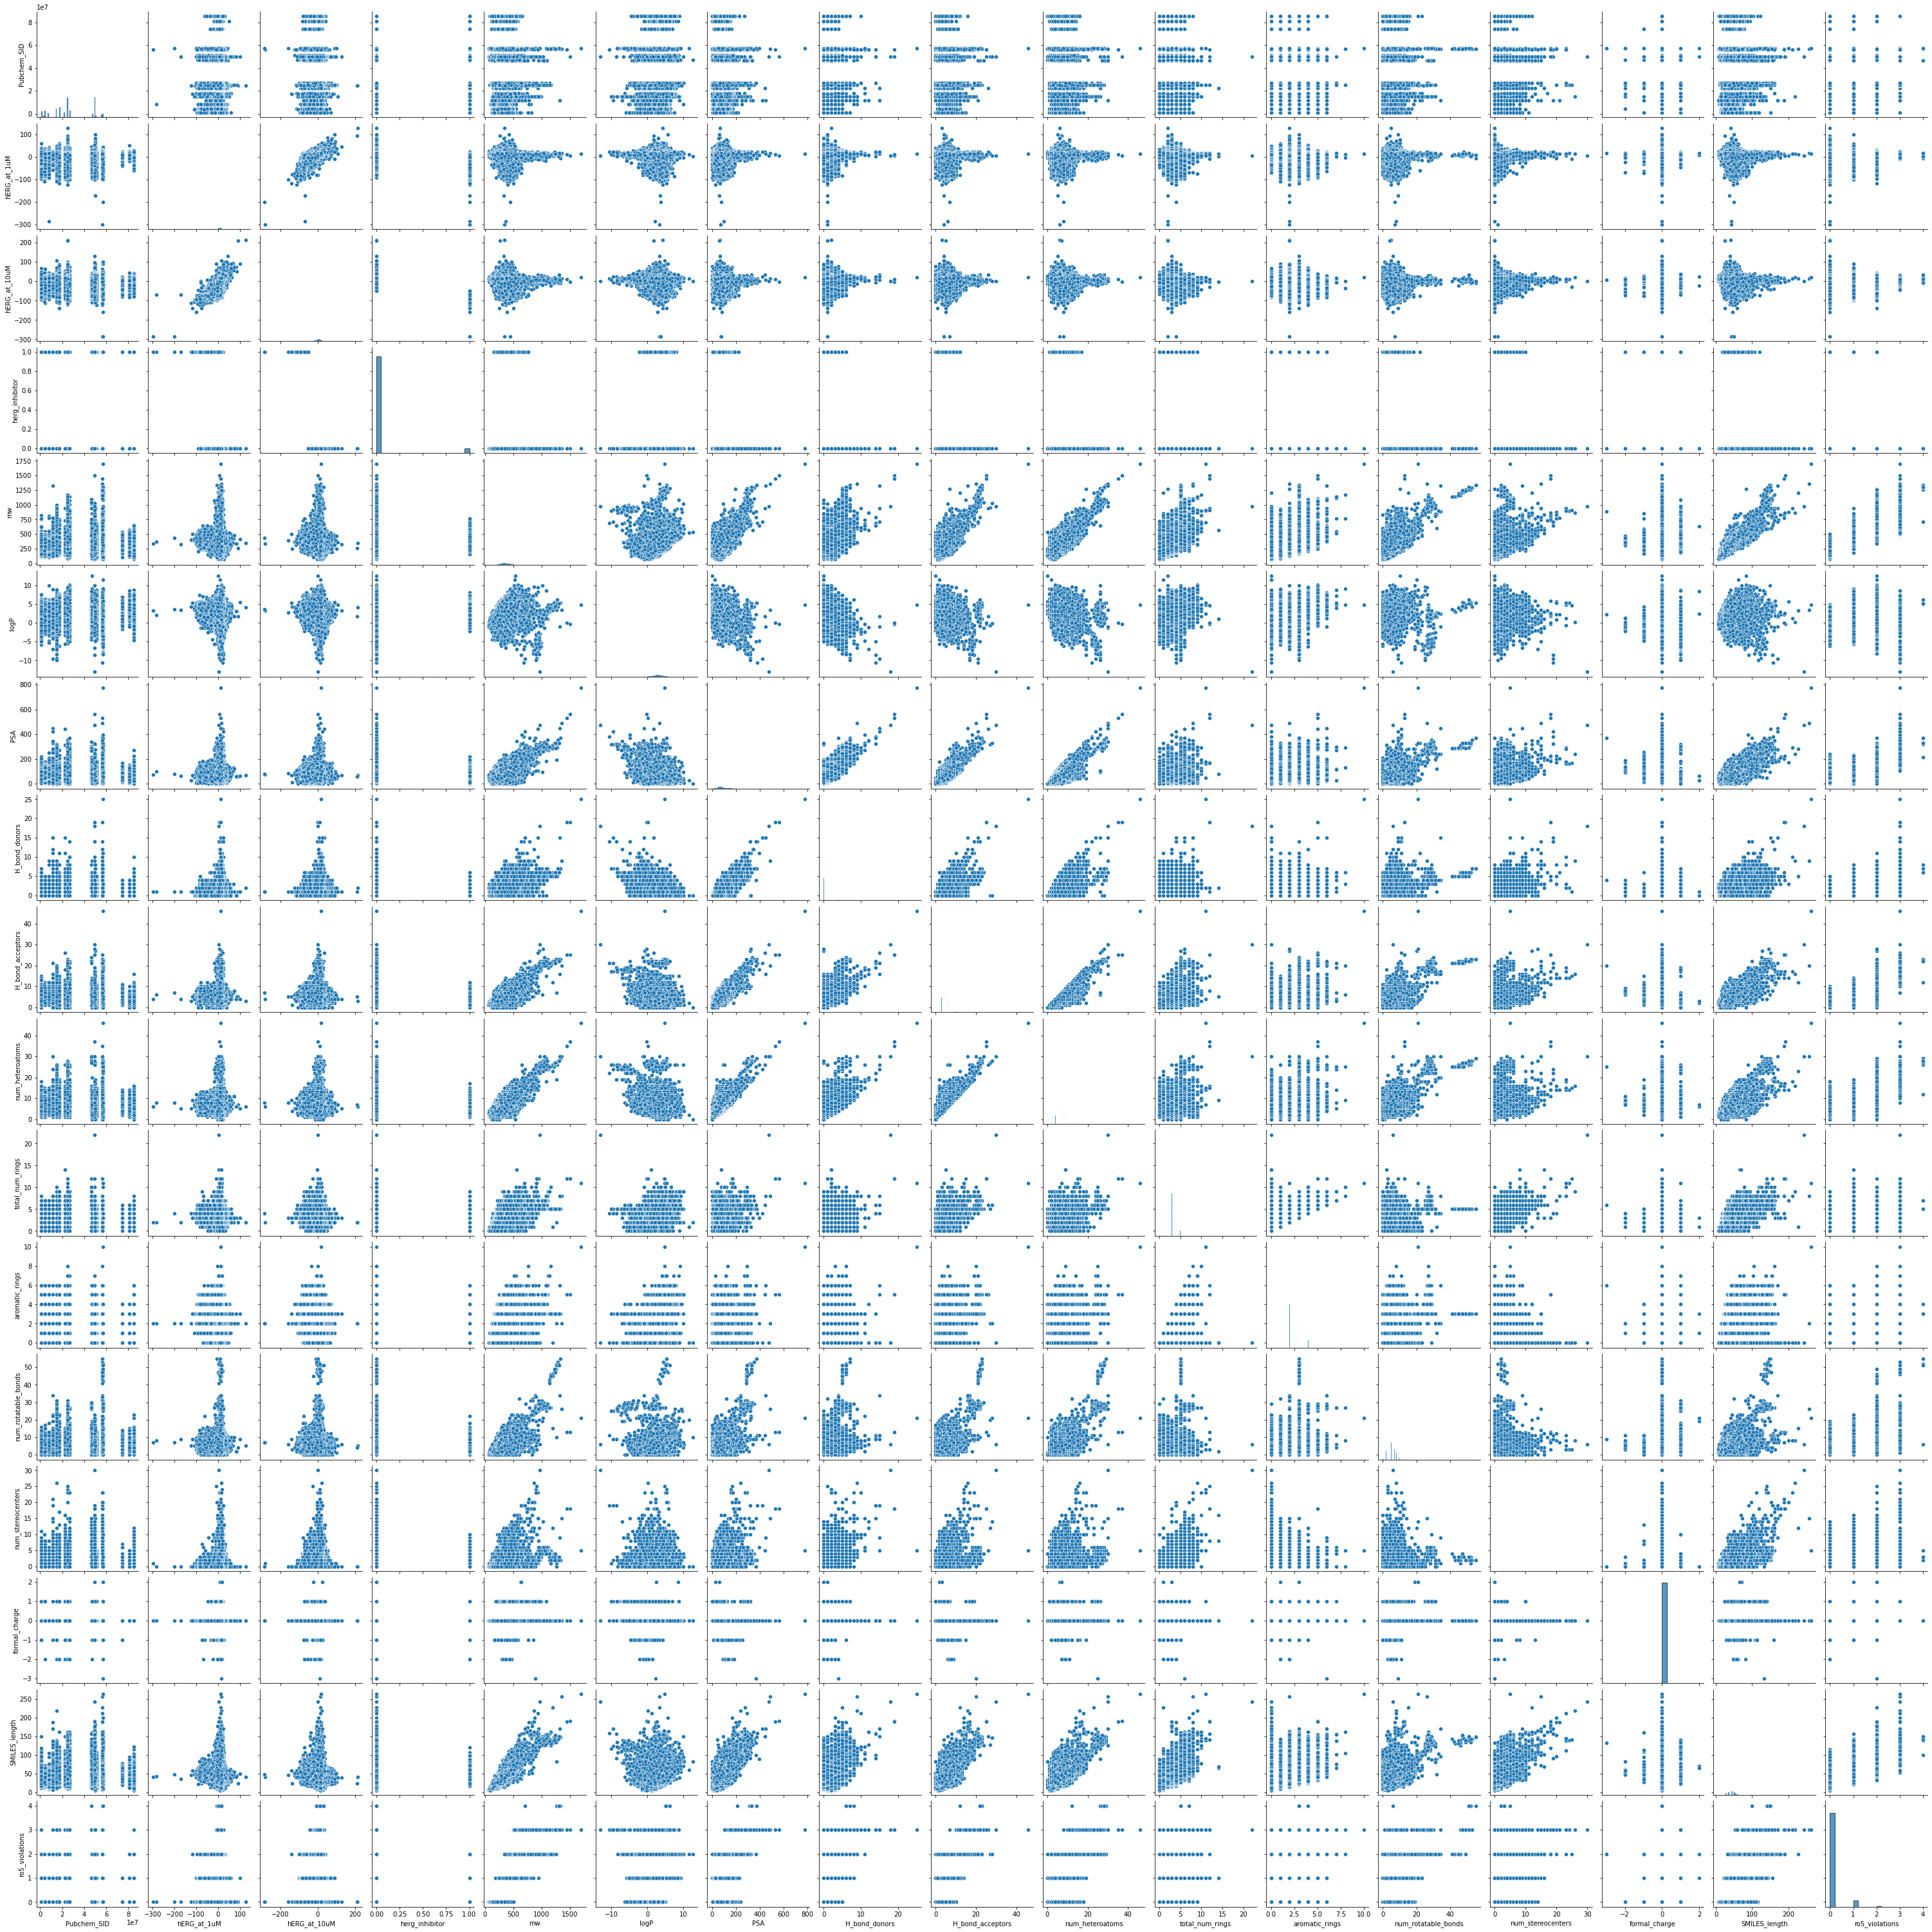

In [31]:
sns.pairplot(herg_df)

Strong correlation between number of rotatable bonds and number of heteroatoms!

Decent correlation between PSA and MW, H-bond acceptors, 

Decent

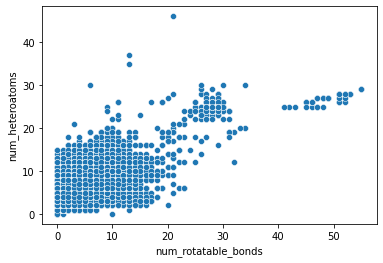

In [32]:
sns.scatterplot(data=herg_df, x='num_rotatable_bonds', y='num_heteroatoms');


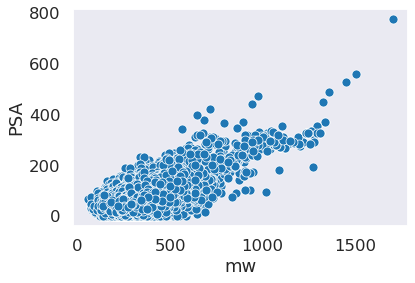

In [71]:
sns.scatterplot(data=herg_df, x='mw', y='PSA');


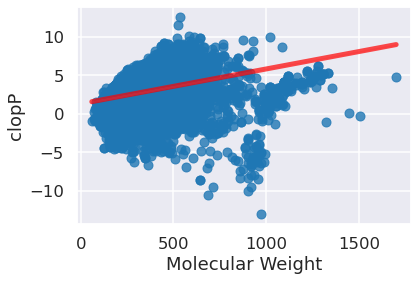

In [18]:
sns.regplot(data=herg_df, x='mw', y='logP', line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlabel('Molecular Weight')
plt.ylabel('clopP');

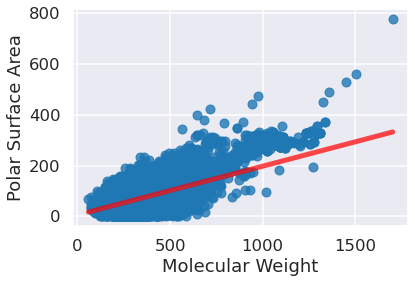

In [17]:
sns.regplot(data=herg_df, x='mw', y='PSA', line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlabel('Molecular Weight')
plt.ylabel('Polar Surface Area');


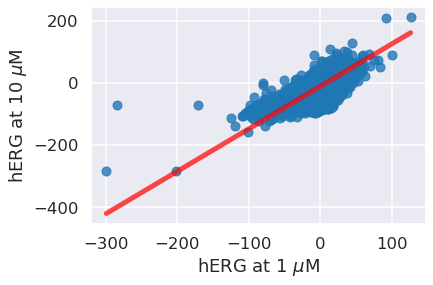

In [56]:
sns.regplot(data=herg_df, x='hERG_at_1uM', y='hERG_at_10uM', line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlabel('hERG at 1 $\mu$M')
plt.ylabel('hERG at 10 $\mu$M');


In [ ]:
PandasTools.FrameToGridImage(herg_df.sample(9), column='Mol', legendsCol='name', molsPerRow=6, subImgSize=(150,150))


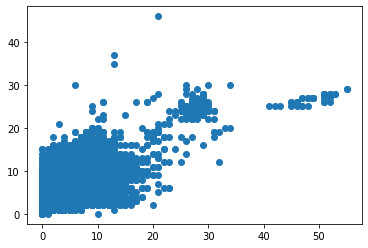

In [33]:
plt.plot('num_rotatable_bonds', 'num_heteroatoms', data=herg_df, linestyle='none', marker='o');

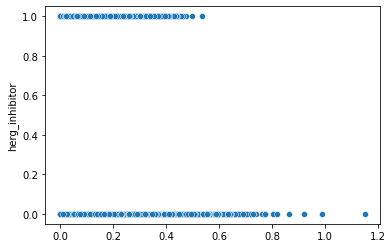

In [34]:
herg_df.PSA / herg_df.mw;
sns.scatterplot(x=herg_df.PSA/herg_df.mw, y=herg_df['herg_inhibitor']);

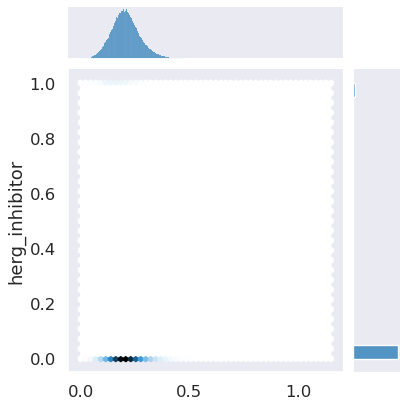

In [75]:
herg_df.PSA / herg_df.mw;
sns.jointplot(x=herg_df.PSA/herg_df.mw, y=herg_df['herg_inhibitor'], kind='hex');

In [63]:
herg_df.PSA / herg_df.mw;
sns.pairplot(herg_df, x_vars=herg_df.PSA/herg_df.mw, y_vars=herg_df['herg_inhibitor']);

MemoryError: Unable to allocate 702. GiB for an array with shape (306865, 306865) and data type object

<Figure size 5.52357e+07x5.52357e+07 with 0 Axes>

In [ ]:
def conv_net():
  K.clear_session()
  weights = 'imagenet'
  inputs = Input(shape=(128, 128, 3))

  base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

  for layer in base_model.layers:
    layer.trainable = False

  x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Flatten()(x)

  base_resnet = base_model(inputs)
  base_resnet = Flatten()(base_resnet)

  concated_layers = Concatenate()([x, base_resnet])

  concated_layers = Dense(2024, activation='relu')(concated_layers)
  concated_layers = Dense(524, activation='relu')(concated_layers)
  concated_layers = Dense(124, activation='relu')(concated_layers)
  output = Dense(4, activation='relu')(concated_layers)

  model = Model(inputs=inputs, outputs=output)
  return model